## NEURAL STYLE TRANSFER


One of the fun ways of implemeting deep learning techniques is in the generation of art, also termed as 'Neural Style Transfer (NST).' The main aim of this algorithm is for the global arrangement of the content (input) image to be preserved, with the colors and the local textures given by the artwork. The resultant image is in the artistic style of the original image.

When synthesizing the images, there is always some discrepancy. Hence, minimizing the loss function after every computation can regulate both the style and content depending on the need. 
- An emphasis on the style in the loss function will result on the output image looking more like the artwork, giving a textured look without any original content in the input image. Hence, a __*trade off*__ between the two losses is catered in this project. 

The NST in computer vision is also termed as a '__Non-photorealistic Rendering__' problem which was conventionaly solved using the Texture Transfer Approach, a non-parametric method. But Deep Neural Networks for object recognition have proven to be more efficient.

In [10]:
## importing necessary libraries
import os
import sys
import scipy
import imageio
from scipy import io
from scipy import misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

## nst_utils has functions for loading the model, normalizing the images and saving generated files.
from nst_utils import *

import numpy as np
import tensorflow as tf

In [ ]:
# selecting content image
content_image = plt.imread("images/louvre.jpg")
imshow(content_image)

In [ ]:
# seleting the style image
style_image = plt.imread("images/monet_800600.jpg")
imshow(style_image)

### How to know if the Generated image 'G', matches the content image 'C'?

In order to achieve this, we compute the cost function of the Content Representations at different layers of the VGG network (CNN). Ideally, a layer which is neither too shallow nor too deep gives most pleasing visual results. 

Let the cost function computed here be termed as the 'content cost function.'

The cost functions of both the content and the style representations is computed. The entire computation is divided into the following functions.

In [11]:
# style representation/matrix
# correlation between different filter responses (feature maps)
# in a CNN layer 'l'

def gram_matrix(A):
    G_A = tf.matmul(A, tf.transpose(A))
    
    return G_A

# computing the content_cost

def content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(m)
    # convert 3D volumes to 2D matrices for simpler computations
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    
    # cost function
    J_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C, a_G))))
    
    return J_content

# computing the  style_cost of a particular layer
def style_cost_layer(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = (1/(4*(n_H*n_W)**2*n_C**2))*(tf.reduce_sum(tf.square(tf.subtract(GS,GG))))
    
    return J_style_layer
    

### Model
The algorithm works on the principle of 'Transfer Learning'. Therefore, a VGG-Network is employed which has 19 layers with the feature space provided by 16 convolutional layers and 5 pooling layers. 

In [12]:
# loading the VGG model
model = load_vgg_model('imagenet-vgg-verydeep-19.mat')

In [13]:
# we calculate style cost for all layers in the NN

STYLELAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)
]

def style_cost(model, STYLELAYERS):
    J_style = 0
    for layer, weight in STYLELAYERS:
        out_tensor = model[layer]
        a_S = sess.run(out_tensor)
        a_G = out_tensor
        J_style_layer = style_cost_layer(a_S, a_G)
        J_style += weight*J_style_layer
    return J_style

In [14]:
# total cost
alpha = 10
beta = 40
def total_cost(J_content, J_style, alpha, beta):
    J = alpha*J_content + beta*J_style
    return J

In [15]:
#### Neural Style Transfer ####
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

C:\Users\Admin\anaconda3\envs\py37\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [56]:
# loading the content and style images
content_image_orig = plt.imread("images/succulents.jpg")
content_image = reshape_and_normalize_image(content_image_orig)

style_image_orig = plt.imread("images/van-gogh-2.jpg")
style_image = reshape_and_normalize_image(style_image_orig)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


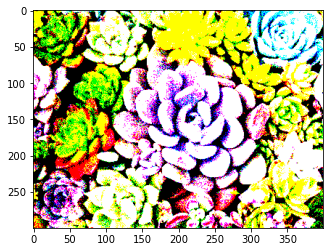

In [57]:
# initializing the generated image
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [58]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [59]:
## assign content image as the input of the VGG model
sess.run(model['input'].assign(content_image))
out_tensor = model['conv4_2']
a_C = sess.run(out_tensor)
a_G = out_tensor
J_content = content_cost(a_C, a_G)

# assign style image as the input of the VGG model
sess.run(model['input'].assign(style_image))
J_style = style_cost(model, STYLELAYERS)


J = total_cost(J_content, J_style, alpha = 10, beta = 40)

1


In [60]:
# defining an aoptimizer
optim = tf.train.AdamOptimizer(2.0)
train_step = optim.minimize(J)

In [ ]:
#path_generated_image = 'output/'+'.png'

In [61]:
## training the model
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            J_T, J_C, J_S = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("Total Cost = " + str(J_T))
            print("Content Cost = " + str(J_C))
            print("Style Cost = " + str(J_S))
            
            #save_image("output/" + str(i) + " .png", generated_image)
    
    # saving the final image in the folder output
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image
        
        

In [62]:
# running the final model for ## iterations
iterations = 200
model_nn(sess, generated_image, iterations)

Iteration 0 :
Total Cost = 2947057700.0
Content Cost = 12115.456
Style Cost = 73673416.0
Iteration 20 :
Total Cost = 374023170.0
Content Cost = 17481.574
Style Cost = 9346209.0
Iteration 40 :
Total Cost = 159504110.0
Content Cost = 19308.154
Style Cost = 3982775.5
Iteration 60 :
Total Cost = 95913230.0
Content Cost = 20435.717
Style Cost = 2392721.8
Iteration 80 :
Total Cost = 70089416.0
Content Cost = 21009.006
Style Cost = 1746983.1
Iteration 100 :
Total Cost = 56248920.0
Content Cost = 21391.322
Style Cost = 1400875.2
Iteration 120 :
Total Cost = 47372416.0
Content Cost = 21703.807
Style Cost = 1178884.4
Iteration 140 :
Total Cost = 41021876.0
Content Cost = 21965.012
Style Cost = 1020055.56
Iteration 160 :
Total Cost = 36159240.0
Content Cost = 22193.66
Style Cost = 898432.56
Iteration 180 :
Total Cost = 32312900.0
Content Cost = 22396.123
Style Cost = 802223.44


array([[[[ 1.20780544e+01,  3.03412838e+01, -6.39491539e+01],
         [ 2.20948830e+01,  3.07171288e+01, -6.92091064e+01],
         [ 5.82867575e+00,  3.89894257e+01, -6.42824173e+01],
         ...,
         [-5.83048296e+00,  2.90465469e+01, -3.01001072e+01],
         [ 7.75027466e+00,  1.59061089e+01, -2.21619415e+01],
         [ 8.10494804e+00,  7.98706055e+00, -2.55844078e+01]],

        [[ 4.30312042e+01,  8.58252945e+01, -7.38994141e+01],
         [ 4.63499565e+01,  6.92203979e+01, -6.59600830e+01],
         [ 5.62303810e+01,  4.95809631e+01, -4.15680389e+01],
         ...,
         [-2.04154797e+01,  4.73839531e+01, -2.83099995e+01],
         [-1.48806620e+00,  3.17616863e+01, -4.85144005e+01],
         [-1.84332609e+00,  4.57513428e+01, -3.76392670e+01]],

        [[ 6.77733459e+01,  8.72045288e+01, -7.60635376e+01],
         [ 6.36228371e+01,  5.20516968e+01, -5.30474892e+01],
         [ 6.32891388e+01,  4.76523170e+01, -4.02789345e+01],
         ...,
         [-1.24204721e+0

In [63]:
final_generated_image = plt.imread("output/generated_image.jpg")

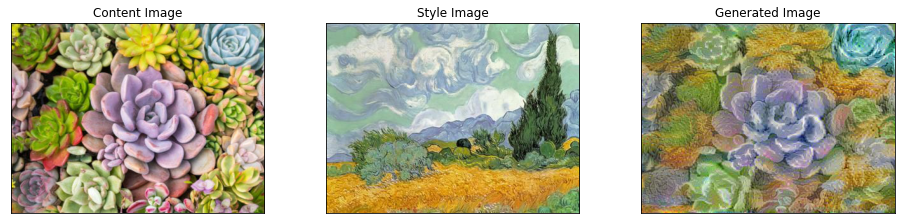

In [64]:
final_images = []
final_images.append(content_image_orig)
final_images.append(style_image_orig)
final_images.append(final_generated_image)

fig, axes = plt.subplots(1,3, figsize = (16,3.5))
titles = ['Content Image', 'Style Image', 'Generated Image']
for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(final_images[i])